# 043 Weighted interpolation : Answers to exercises

#### Exercise 1

* Write a function `get_weight` that takes as argument:
    
        lai  : MODIS LAI dataset
        std  : MODIS LAI uncertainty dataset 
        
  and returns an array the same shape as lai/std of per-pixel pixel weights
* Read a MODIS LAI dataset, calculate the weights, and print some statistics of the weights


In [2]:
# ANSWER
'''
a function `get_weight` that takes as argument:

lai  : MODIS LAI dataset
std  : MODIS LAI uncertainty dataset 
'''
def get_weight(lai,std):
    std[std<1] = 1
    weight = np.zeros_like(std)
    mask = (std > 0)
    weight[mask] = 1./(std[mask]**2)
    weight[lai > 10] = 0.

    return weight

In [3]:
# ANSWER

from geog0111.modisUtils import getLai
# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"
lai,std,doy =  getLai(year,tile,fips)

weight = get_weight(lai,std)
print(f'weight min:    {weight.min()}')
print(f'weight max:    {weight.max()}')
print(f'weight mean:   {weight.mean()}')
print(f'weight median: {np.median(weight)}')
print(f'weight sum:    {weight.sum()}')

weight min:    0.0
weight max:    1.0
weight mean:   0.3190312602956545
weight median: 0.0016259105098855356
weight sum:    626641.2014727246


#### Exercise 2

* Write a function `regularise` that takes as argument:
    
        lai     : MODIS LAI dataset
        weight  : MODIS LAI weight
        sigma   : Gaussian filter width
        
  and returns an array the same shape as lai of regularised LAI
* Read a MODIS LAI dataset and regularise it
* Plot original LAI, and regularised LAI for varying values of sigma, for one pixel

Hint: You will find such a function useful when completing Part B of the assessed practical, so it is well worth your while doing this exercise.

In [10]:
# ANSWER
import numpy as np
import scipy
import scipy.ndimage.filters

# regularise
def regularise(lai,weight,sigma):
    '''
    takes as argument:
    
        lai     : MODIS LAI dataset:     shape (Nt,Nx,Ny)
        weight  : MODIS LAI weight:      shape (Nt,Nx,Ny)
        sigma   : Gaussian filter width: float
        
    returns an array the same shape as 
    lai of regularised LAI. Regularisation takes place along
    axis 0 (the time axis)
    '''
    x = np.arange(-3*sigma,3*sigma+1)
    gaussian = np.exp((-(x/sigma)**2)/2.0)

    numerator = scipy.ndimage.filters.convolve1d(lai * weight, gaussian, axis=0,mode='wrap')
    denominator = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')

    # avoid divide by 0 problems by setting zero values
    # of the denominator to not a number (NaN)
    denominator[denominator==0] = np.nan

    interpolated_lai = numerator/denominator
    # (Nt,Nx,Ny)
    return interpolated_lai


In [11]:
# Read a MODIS LAI dataset and regularise it
# ANSWER


import numpy as np
from geog0111.modisUtils import getLai
from geog0111.modisUtils import get_weight

# load some data
tile    = ['h17v03','h18v03','h17v04','h18v04']
year    = 2019
fips    = "LU"
sigma   = 5

lai,std,doy =  getLai(year,tile,fips)

weight = get_weight(lai,std)

# make a dictionary
interpolated_lai = {}
for sigma in [2,5,10,20,30]:
    interpolated_lai[sigma] = regularise(lai,weight,sigma)

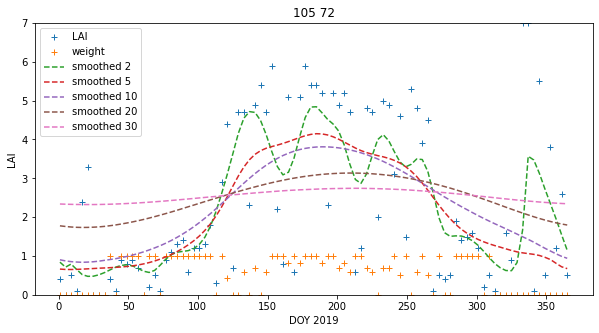

In [12]:
import matplotlib.pyplot as plt
# ANSWER

p0,p1 = 105,72
x_size,y_size=(10,5)

fig, axs = plt.subplots(1,1,figsize=(x_size,y_size))
x = doy
axs.plot(x,lai[:,p0,p1],'+',label='LAI')
axs.plot(x,weight[:,p0,p1],'+',label='weight')

axs.set_title(f'{p0} {p1}')
# ensure the same scale for all
axs.set_ylim(0,7)
axs.set_xlabel('DOY 2019')
axs.set_ylabel('LAI')

for sigma in [2,5,10,20,30]:
    axs.plot(x,interpolated_lai[sigma][:,p0,p1],'--',label=f'smoothed {sigma}')


axs.legend(loc='best')

#### Exercise 3

* Write a function `get_lc` that takes as argument:
    
        year    : int
        tile    : list of MODIS tiles, list of st
        fips    : country FIPS code, str
        
  and returns a byte array of land cover type LC_Type3 for the year and country specified
* In your function, print out the unique values in the landcover dataset to give some feedback to the user
* Write a function `plot_LC_Type3` that will plot LC_Type3 data with an appropriate colourmap.
* Produce a plot of the land cover of Belgium for 2018

In [20]:
# ANSWER
from geog0111.modisUtils import modisAnnual

import gdal
import numpy as np

def get_lc(year,tile,fips):
    '''
    Return LC mask for year,tile,fips
    '''
    # SDS for land cover data
    LC_SDS = ['LC_Prop1', 'LC_Prop1_Assessment', 'LC_Prop2', \
              'LC_Prop2_Assessment', 'LC_Prop3', 'LC_Prop3_Assessment', \
              'LC_Type1', 'LC_Type2', 'LC_Type3', 'LC_Type4', 'LC_Type5', 'LW', 'QC']

    warp_args = {
        'dstNodata'     : 255,
        'format'        : 'MEM',
        'cropToCutline' : True,
        'cutlineWhere'  : f"FIPS='{fips}'",
        'cutlineDSName' : 'data/TM_WORLD_BORDERS-0.3.shp'
    }
    # LU

    kwargs = {
        'tile'      :    tile,
        'product'   :    'MCD12Q1',
        'year'      :    year,
        'sds'       : LC_SDS,
        'doys'      :    [1],
        'warp_args' : warp_args
    }

    # get the data
    lcfiles,bnames = modisAnnual(**kwargs)
    
    # get the item we want
    g = gdal.Open(lcfiles['LC_Type3'])
    # error checking
    if not g:
        print(f"cannot open LC file {lcfiles['LC_Type3']}")
        return None
    lc = g.ReadAsArray()
    del g
    
    # in your function, print out the unique values in the 
    # landcover dataset to give some feedback to the user
    print(f"class codes: {np.unique(lc)}")
    return lc

In [21]:
# ANSWER
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches
import pandas as pd

def plot_LC_Type3(land_cover):
    # read the colour data
    lc_Type3 = pd.read_csv('data/LC_Type3_colour.csv')   
    # set up cmap and norm for colour scale
    cmap = matplotlib.colors.\
            ListedColormap(list(lc_Type3['colour']))
    norm = matplotlib.colors.\
            BoundaryNorm(list(lc_Type3['code']), len(lc_Type3['code']))

    # set up the legend
    legend_labels = dict(zip(list(lc_Type3['colour']),list(lc_Type3['class'])))
    patches = [matplotlib.patches.Patch(color=c, label=l)
               for c,l in legend_labels.items()]

    x_size,y_size=(10,10)
    fig, axs = plt.subplots(1,figsize=(x_size,y_size))
    im = axs.imshow(land_cover,cmap=cmap,norm=norm,interpolation='nearest')
    plt.legend(handles=patches,
              bbox_to_anchor=(1.4, 1),
              facecolor="white")

class codes: [  1   3   4   5   6   7  10 255]


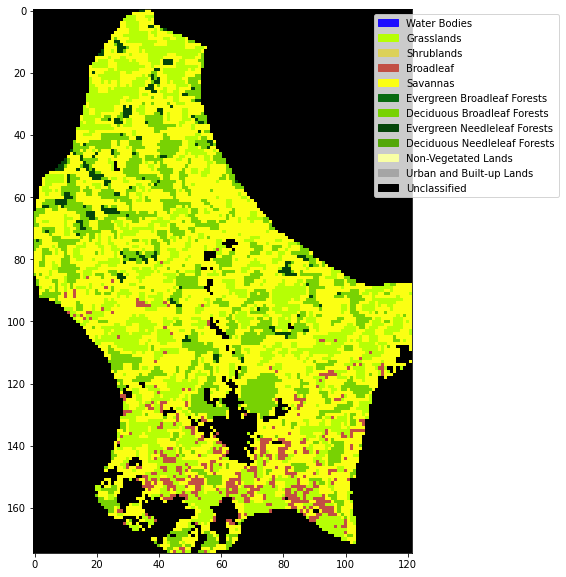

In [22]:
# Produce a plot of the land cover of Belgium for 2018
# ANSWER
year = 2018
fips = "BE"
tile = ['h17v03', 'h18v03','h17v04', 'h18v04']
lc = get_lc(year,tile,fips)
plot_LC_Type3(lc)